In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
import spacy
from empath import Empath
import scipy.sparse as sp
from sklearn.linear_model import PassiveAggressiveClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/aishwarya/nltk_data...
[nltk_data]   Package words is already up-to-date!


<h2>Data Preparation</h2>

In [9]:
# import first dataset 'data.csv'
df = pd.read_csv("/Users/aishwarya/Desktop/Mini_Project/data.csv");

# inspect shape
print(df.shape)

# inspect columns
print(df.columns)

# inspect first few rows
df.head()

(4009, 4)
Index(['URLs', 'Headline', 'Body', 'Label'], dtype='object')


,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [10]:
# rename labels from 0 to 'REAL' and 1 to 'FAKE'
df.loc[df['Label']== 1, 'Label'] = 'REAL'
df.loc[df['Label']== 0, 'Label'] = 'FAKE'

# drop the column URLs from table
df.drop(['URLs'], axis = 1, inplace = True)
df.head()

,Headline,Body,Label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,REAL
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",REAL
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,REAL
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,REAL
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",REAL


In [11]:

# import second dataset 'fake.csv' which contains incorrect news 
df1 = pd.read_csv("/Users/aishwarya/Desktop/Mini_Project/fake.csv");

print(df1.columns)


# print all kinds of incorrect news
print(df1['type'].value_counts())

# select only fake news 
df1 = df1.loc[df1['type']=='fake']
df1.loc[df1['type'] == 'fake', 'type'] = 'FAKE'


# selecting only title, text and type and renaming them
df1 = df1[['title', 'text', 'type']]
df1.columns = ['Headline', 'Body', 'Label']

df1.head()

Index(['uuid', 'ord_in_thread', 'author', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'domain_rank',
       'thread_title', 'spam_score', 'main_img_url', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'type'],
      dtype='object')
bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: type, dtype: int64


,Headline,Body,Label
57,The Amish In America Commit Their Vote To Dona...,18 SHARE The Amish in America have committed t...,FAKE
58,Obama Signs Executive Order Declaring Investig...,64 SHARE President Obama has signed an Executi...,FAKE
379,Comment on HALLOWEEN IN THE CASTRO RETURNS IN ...,"adobochron 10 Comments \nSan Francisco, Califo...",FAKE
380,Comment on Tutorial: Riding The Philippine Jee...,"adobochron 1 Comment \nMANILA, Philippines (Th...",FAKE
381,Comment on What White House Executive Chef Com...,"adobochron 1 Comment Comerford \nWASHINGTON, D...",FAKE


In [12]:
# import third dataset 'fake_or_real_news.csv'
df2 = pd.read_csv("/Users/aishwarya/Desktop/Mini_Project/fake_or_real_news.csv")

df2.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [13]:
# select only columns title, text and label
df2 = df2[['title', 'text', 'label']]

# rename the column names
df2.columns = ['Headline', 'Body', 'Label']

df2.head()

,Headline,Body,Label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [14]:
# importing fourth dataset 'train.csv'
df3 = pd.read_csv("/Users/aishwarya/Desktop/Mini_Project/train.csv")

df3.head()


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [15]:
# select only title, text and label columns
df3 = df3[['title', 'text', 'label']]

# rename the columns
df3.columns = ['Headline', 'Body', 'Label']

# rename the labels names from 0 and 1 to REAL and FAKE
df3.loc[df3['Label'] == 0, 'Label'] = 'REAL'
df3.loc[df3['Label'] == 1, 'Label'] = 'FAKE'

df3.head()

,Headline,Body,Label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,FAKE
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,REAL
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",FAKE
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,FAKE
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,FAKE


In [16]:
# combine all the four datasets
df = df.append(df1, ignore_index = True)
df = df.append(df2, ignore_index = True)
df = df.append(df3, ignore_index = True)

print(df.shape)

df.head()


(31163, 3)


,Headline,Body,Label
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,REAL
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",REAL
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,REAL
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,REAL
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",REAL


<h2>Data Preprocessing</h2>

In [17]:
# drop any duplicate data points
df = df.drop_duplicates()

print(df.shape)

(28019, 3)


In [18]:
# drop from df if length of the news article is less than 10 
i = 0
ind = []

for article in df['Body']:
    if len(str(article)) < 10:
        ind.append(i)
    i = i + 1
    
df = df.drop(df.index[ind])
print(df.shape)

# drop any null values
df.dropna(inplace=True)

print(df.shape)
        

(27865, 3)
(27356, 3)


In [19]:
# inspect the ratio of labels
df['Label'].value_counts()

REAL    15259
FAKE    12097
Name: Label, dtype: int64

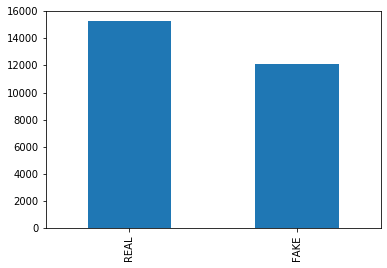

In [20]:
df['Label'].value_counts().plot(kind = 'bar')

In [21]:
# combining Headine and Body 
df['Text'] = df['Headline'] + " " + df['Body']

df.head()


,Headline,Body,Label,Text
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,REAL,Four ways Bob Corker skewered Donald Trump Ima...
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",REAL,Linklater's war veteran comedy speaks to moder...
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,REAL,Trump’s Fight With Corker Jeopardizes His Legi...
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,REAL,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",REAL,Jason Aldean opens 'SNL' with Vegas tribute Co...


In [22]:
# Clean text
def clean_text(text):
    # remove punctuation
    text = re.sub('['+string.punctuation+']', '', text)
    text = re.sub(r"[-()\"#/@’;:<>{}`+=~|.!?,]", "", text)
    
    # convert words to lower case and split
    text = text.lower().split()
    
    # remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if w not in stops]
    text = " ".join(text)
    
    # remove all non english and numbers etc.
    text = re.sub(r'[^a-zA-Z\s]', u'', text, flags=re.UNICODE)
    
    # lemmatizing
    text = text.split()
    l = WordNetLemmatizer()
    lemmatized_words = [l.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    
    return text

# apply clean_text on Text columnxx
df['Clean_Text'] = df['Text'].apply(lambda x: clean_text(x))
df.dropna(inplace=True)
    

In [23]:
df.head()

,Headline,Body,Label,Text,Clean_Text
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,REAL,Four ways Bob Corker skewered Donald Trump Ima...,four way bob corker skewered donald trump imag...
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",REAL,Linklater's war veteran comedy speaks to moder...,linklaters war veteran comedy speaks modern am...
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,REAL,Trump’s Fight With Corker Jeopardizes His Legi...,trump fight corker jeopardizes legislative age...
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,REAL,Egypt's Cheiron wins tie-up with Pemex for Mex...,egypt cheiron win tieup pemex mexican onshore ...
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",REAL,Jason Aldean opens 'SNL' with Vegas tribute Co...,jason aldean open snl vega tribute country sin...


<h2> Splitting into training and testing sets </h2>

In [24]:
# set y
y = df['Label'].astype('str') 

# Make train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Clean_Text'], y, test_size = 0.33, random_state = 53)

print(X_train.head())
print()
print(y_train.head())


27534    guilt quiz guilt level chart tool guilted age ...
12973    mainstream medium monopoly arrival new medium ...
5240     comment strange fact president tania de saram ...
17740               rt arabic gmt httparrtcomigk rt arabic
1035     odell beckham jr new york giant wide receiver ...
Name: Clean_Text, dtype: object

27534    FAKE
12973    FAKE
5240     FAKE
17740    FAKE
1035     REAL
Name: Label, dtype: object


<h2>TFIDF Vectorization</h2>

In [25]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2, 2))

tfidf_train = tfidf_vectorizer.fit_transform(X_train)

tfidf_test = tfidf_vectorizer.transform(X_test)

print(tfidf_vectorizer.get_feature_names()[:10])

['aa aa', 'aa armament', 'aa ball', 'aa birmingham', 'aa classmate', 'aa coveted', 'aa division', 'aa fa', 'aa firecontrol', 'aa firepower']


In [26]:
# confusion matrix function definition
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.ylim([1.5, -.5])
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


ACCURACY 0.8390562693841382
Confusion Matrix: 
[[2507 1429]
 [  24 5068]]


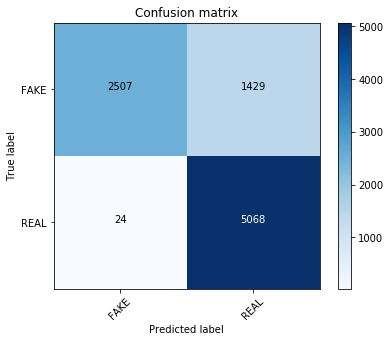

In [27]:
# naive Bayes model for TFIDF bigrams
nb_classifier = MultinomialNB(alpha=0.0)

nb_classifier.fit(tfidf_train, y_train)

pred = nb_classifier.predict(tfidf_test)

# calculate and print accuracy of model
score = metrics.accuracy_score(y_test, pred)
print('ACCURACY', score)

# calculate and print confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print('Confusion Matrix: ')
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])


In [28]:
# improving naive bayes model by testing with different alpha levels

alphas = np.arange(0, 1, 0.1)

# define train_and_predict()
def train_and_predict(alpha):
    # instantiate the classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # fit to training data
    nb_classifier.fit(tfidf_train, y_train)
    # predict the labels
    pred = nb_classifier.predict(tfidf_test)
    # calculate accuracy score
    score = metrics.accuracy_score(y_test, pred)
    return score



# iterate over alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.8390562693841382

Alpha:  0.1
Score:  0.8913380593708462

Alpha:  0.2
Score:  0.8732831191847585

Alpha:  0.30000000000000004
Score:  0.8620957022596367

Alpha:  0.4
Score:  0.8535666814355339

Alpha:  0.5
Score:  0.8460345591493132

Alpha:  0.6000000000000001
Score:  0.8407177669472752

Alpha:  0.7000000000000001
Score:  0.8363978732831192

Alpha:  0.8
Score:  0.8319672131147541

Alpha:  0.9
Score:  0.8287549844926894



/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ACCURACY:  0.8812583074878156
Confusion Matrix: 
[[3563  373]
 [ 699 4393]]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


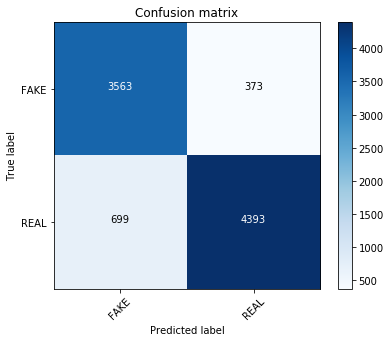

In [29]:
# random forest model for TFIDF bigrams
rf_classifier = RandomForestClassifier(verbose=True)

rf_classifier.fit(tfidf_train, y_train)

pred = rf_classifier.predict(tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print('ACCURACY: ', score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print('Confusion Matrix: ')
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])



      Iter       Train Loss   Remaining Time 
         1           1.3142           14.30m
         2           1.2652           13.81m
         3           1.2233           13.48m
         4           1.1889           13.21m
         5           1.1583           12.97m
         6           1.1322           12.76m
         7           1.1099           12.65m
         8           1.0903           12.62m
         9           1.0730           12.42m
        10           1.0576           12.21m
        20           0.9620           10.88m
        30           0.9155            9.37m
        40           0.8819            8.09m
        50           0.8545            6.87m
        60           0.8290            5.56m
        70           0.8090            4.19m
        80           0.7898            2.77m
        90           0.7739            1.37m
       100           0.7576            0.00s
ACCURACY:  0.8489144882587506
Confusion Matrix: 
[[3710  226]
 [1138 3954]]


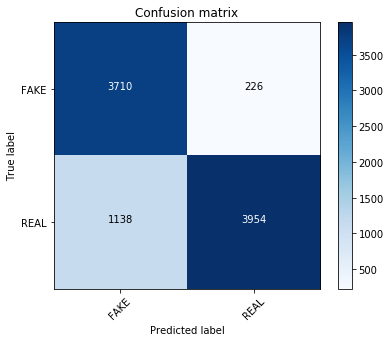

In [30]:
# gradiant Boost model for TFIDF bigrams
gb_classifier = GradientBoostingClassifier(verbose=True)

gb_classifier.fit(tfidf_train, y_train)

pred = gb_classifier.predict(tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print('ACCURACY: ', score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print('Confusion Matrix: ')
print(cm)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<h2> POS Tagging </h2>

In [67]:
# Generate POS tags 
nlp = spacy.load('en')

pos_tags_column = []

for text in df['Text']:
    pos_tags = []
    doc = nlp(text)
    for token in doc:
        pos_tags.append(token.pos_)
    all_pos_tags = ' '.join(pos_tags)
    pos_tags_column.append(all_pos_tags)
    
df['Text_POS'] = pos_tags_column

df.head()



,Headline,Body,Label,Text,Clean_Text,Text_POS,Semantic,Semantics
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,REAL,Four ways Bob Corker skewered Donald Trump Ima...,four way bob corker skewered donald trump imag...,NUM NOUN PROPN PROPN VERB PROPN PROPN PROPN NO...,"[2.0, 6.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, ...",help help office office office office office o...
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",REAL,Linklater's war veteran comedy speaks to moder...,linklaters war veteran comedy speaks modern am...,PROPN PART NOUN NOUN NOUN VERB ADP ADJ PROPN P...,"[1.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, ...",help office office office wedding wedding cold...
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,REAL,Trump’s Fight With Corker Jeopardizes His Legi...,trump fight corker jeopardizes legislative age...,PROPN PROPN PROPN ADP PROPN PROPN DET ADJ PROP...,"[1.0, 9.0, 1.0, 2.0, 5.0, 3.0, 0.0, 2.0, 0.0, ...",help office office office office office office...
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,REAL,Egypt's Cheiron wins tie-up with Pemex for Mex...,egypt cheiron win tieup pemex mexican onshore ...,PROPN PART PROPN VERB VERB PUNCT NOUN ADP PROP...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",banking play business business sports sports h...
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",REAL,Jason Aldean opens 'SNL' with Vegas tribute Co...,jason aldean open snl vega tribute country sin...,PROPN PROPN VERB PUNCT PROPN PUNCT ADP PROPN N...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",cold occupation school art weather music music...


In [68]:
# split into training and testing sets using Text_POS 
y = df['Label'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(df['Text_POS'], y, test_size = 0.33, random_state = 53)
print(X_train.head())
print(y_train.head())


27534    PROPN PROPN CCONJ PROPN PROPN PROPN PUNCT NOUN...
12973    DET PROPN PROPN PROPN VERB ADP DET NOUN ADP AD...
5240     NOUN ADP NUM ADJ NOUN ADP DET NOUN ADP NOUN X ...
17740    ADJ NOUN VERB NOUN NOUN NOUN ADP NOUN PUNCT NO...
1035     PROPN PROPN PROPN PUNCT PROPN PROPN PROPN ADJ ...
Name: Text_POS, dtype: object
27534    FAKE
12973    FAKE
5240     FAKE
17740    FAKE
1035     REAL
Name: Label, dtype: object


In [69]:
# Generating TFIDF bigrams of POS tags
pos_tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (2,2))
pos_tfidf_train = pos_tfidf_vectorizer.fit_transform(X_train.astype('str'))
pos_tfidf_test= pos_tfidf_vectorizer.transform(X_test.astype('str'))
pos_tfidf_vectorizer.get_feature_names()[:10]

['adj adj',
 'adj adp',
 'adj adv',
 'adj aux',
 'adj cconj',
 'adj det',
 'adj intj',
 'adj noun',
 'adj num',
 'adj pron']

Accuracy with Multinomial Naive Bayes: 0.683


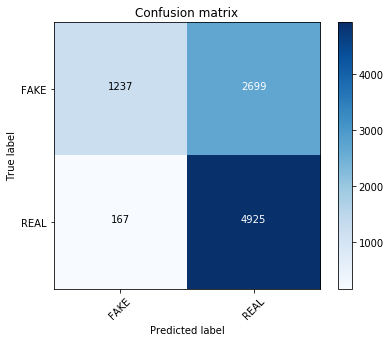

In [70]:
# naive bayes model for POS 
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(pos_tfidf_train, y_train)
pred = nb_classifier.predict(pos_tfidf_test)

#accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes: %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy with RandomForestClassifier:   0.867


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


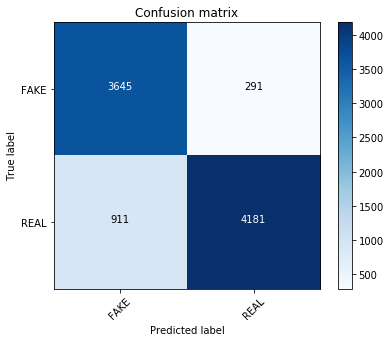

In [71]:
# random forest model for POS
rf_classifier = RandomForestClassifier(verbose=True)
rf_classifier.fit(pos_tfidf_train, y_train)
pred = rf_classifier.predict(pos_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

      Iter       Train Loss   Remaining Time 
         1           1.2907           43.12s
         2           1.2215           41.87s
         3           1.1632           41.02s
         4           1.1136           40.62s
         5           1.0716           40.45s
         6           1.0350           39.99s
         7           1.0036           39.67s
         8           0.9752           39.12s
         9           0.9498           38.61s
        10           0.9281           38.16s
        20           0.7783           33.69s
        30           0.7064           29.38s
        40           0.6553           25.13s
        50           0.6134           20.91s
        60           0.5820           16.72s
        70           0.5535           12.53s
        80           0.5307            8.37s
        90           0.5115            4.19s
       100           0.4951            0.00s
Accuracy with Gradient Boosting:   0.896


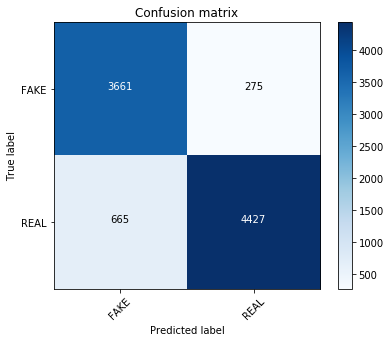

In [72]:
# gradient boost for POS
gb_classifier = GradientBoostingClassifier(verbose=True)
gb_classifier.fit(pos_tfidf_train, y_train)
pred = gb_classifier.predict(pos_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<h2>Semantic Analysis</h2>

In [73]:
# Getting semantic categories scores
lexicon = Empath()
semantic = []
count = 0

for article in df['Text']:
    d = lexicon.analyze(article, normalize=False)
    x = []
    for key, value in d.items():
        x.append(value)
    x = np.asarray(x)
    semantic.append(x)
df['Semantic'] = semantic
print(df['Semantic'].head())

0    [2.0, 6.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, ...
1    [1.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, ...
2    [1.0, 9.0, 1.0, 2.0, 5.0, 3.0, 0.0, 2.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
Name: Semantic, dtype: object


In [74]:
# all categories
categories = []
a = lexicon.analyze("")
for key, value in a.items():
    categories.append(key)
categories

['help',
 'office',
 'dance',
 'money',
 'wedding',
 'domestic_work',
 'sleep',
 'medical_emergency',
 'cold',
 'hate',
 'cheerfulness',
 'aggression',
 'occupation',
 'envy',
 'anticipation',
 'family',
 'vacation',
 'crime',
 'attractive',
 'masculine',
 'prison',
 'health',
 'pride',
 'dispute',
 'nervousness',
 'government',
 'weakness',
 'horror',
 'swearing_terms',
 'leisure',
 'suffering',
 'royalty',
 'wealthy',
 'tourism',
 'furniture',
 'school',
 'magic',
 'beach',
 'journalism',
 'morning',
 'banking',
 'social_media',
 'exercise',
 'night',
 'kill',
 'blue_collar_job',
 'art',
 'ridicule',
 'play',
 'computer',
 'college',
 'optimism',
 'stealing',
 'real_estate',
 'home',
 'divine',
 'sexual',
 'fear',
 'irritability',
 'superhero',
 'business',
 'driving',
 'pet',
 'childish',
 'cooking',
 'exasperation',
 'religion',
 'hipster',
 'internet',
 'surprise',
 'reading',
 'worship',
 'leader',
 'independence',
 'movement',
 'body',
 'noise',
 'eating',
 'medieval',
 'zest',


In [75]:
# Generating semantic classes from semantic score frequency
sem = []
for i in range(df.shape[0]):
    a = []
    for j in range(len(semantic[0])):
        for k in range(int(semantic[i][j])):
            a.append(categories[j])
    b = " ".join(a)
    sem.append(b)
df['Semantics'] = sem

print(df['Semantics'].head())


0    help help office office office office office o...
1    help office office office wedding wedding cold...
2    help office office office office office office...
3    banking play business business sports sports h...
4    cold occupation school art weather music music...
Name: Semantics, dtype: object


In [76]:
# splitting in training and testing sets for Semantic analysis
y = df['Label'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(df['Semantics'], y, test_size = 0.33, random_state = 53)
print(X_train.head())
print(y_train.head())

27534    help help help help help help help help help h...
12973    help money money sleep medical_emergency aggre...
5240     help help office money wedding wedding domesti...
17740                                                     
1035     medical_emergency medical_emergency medical_em...
Name: Semantics, dtype: object
27534    FAKE
12973    FAKE
5240     FAKE
17740    FAKE
1035     REAL
Name: Label, dtype: object


In [77]:
# Generating TFIDF vectors of the semantic unigrams
sem_tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
sem_tfidf_train = sem_tfidf_vectorizer.fit_transform(X_train.astype('str'))
sem_tfidf_test = sem_tfidf_vectorizer.transform(X_test.astype('str'))


Accuracy with Multinomial Naive Bayes:   0.641


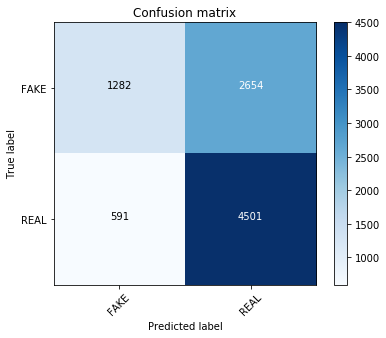

In [78]:
# naive bayes model for semantic analsysis
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(sem_tfidf_train, y_train)
pred = nb_classifier.predict(sem_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy with RandomForestClassifier:   0.704


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


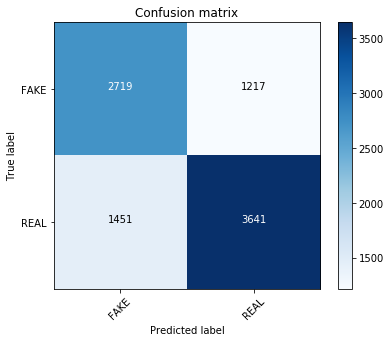

In [79]:
# random forest model for semantic analysis
rf_classifier = RandomForestClassifier(verbose=True)
rf_classifier.fit(sem_tfidf_train, y_train)
pred = rf_classifier.predict(sem_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with RandomForestClassifier:   %0.3f" % score)

# confusion matrix 
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

      Iter       Train Loss   Remaining Time 
         1           1.3453           34.64s
         2           1.3218           33.52s
         3           1.3018           33.04s
         4           1.2849           32.57s
         5           1.2700           32.15s
         6           1.2558           31.76s
         7           1.2443           31.39s
         8           1.2332           31.14s
         9           1.2236           30.78s
        10           1.2144           30.42s
        20           1.1526           26.96s
        30           1.1142           23.76s
        40           1.0868           20.40s
        50           1.0653           17.03s
        60           1.0466           13.63s
        70           1.0301           10.24s
        80           1.0156            6.84s
        90           1.0031            3.43s
       100           0.9905            0.00s
Accuracy with Gradient Boosting:   0.733


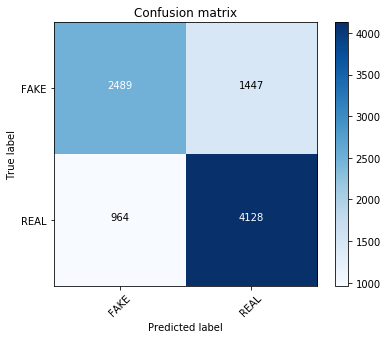

In [80]:
# gradient boosting model for semantic analysis
gb_classifier = GradientBoostingClassifier(verbose=True)
gb_classifier.fit(sem_tfidf_train, y_train)
pred = gb_classifier.predict(sem_tfidf_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Gradient Boosting:   %0.3f" % score)

# confusion matrix 
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<h2>Combining the 3 features - TFIDF, POS and Semantic </h2>

In [81]:
print(df.columns)
print(df.shape)

# drop label from df to create X
X = df.drop('Label', axis = 1)

print(X.columns)

Index(['Headline', 'Body', 'Label', 'Text', 'Clean_Text', 'Text_POS',
       'Semantic', 'Semantics'],
      dtype='object')
(27356, 8)
Index(['Headline', 'Body', 'Text', 'Clean_Text', 'Text_POS', 'Semantic',
       'Semantics'],
      dtype='object')


In [82]:
# take Label as y
y = df.Label

# split into training and testing sets using X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 53)


In [83]:
X_train_text = X_train['Clean_Text']
X_test_text = X_test['Clean_Text']

X_train_POS = X_train['Text_POS']
X_test_POS = X_test['Text_POS']

X_train_sem = X_train['Semantics']
X_test_sem = X_test['Semantics']

In [84]:
# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,3), max_features=20000)
tfidf_train = tfidf_vectorizer.fit_transform(X_train_text.astype('str'))
tfidf_test = tfidf_vectorizer.transform(X_test_text.astype('str'))


In [85]:
# POS TFIDF Vectorizer
pos_tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,3), max_features=20000)
pos_tfidf_train = pos_tfidf_vectorizer.fit_transform(X_train_POS.astype('str'))
pos_tfidf_test = pos_tfidf_vectorizer.transform(X_test_POS.astype('str'))

In [86]:
# Semantic TFIDF Vectorizer
sem_tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_features=20000)
sem_tfidf_train = sem_tfidf_vectorizer.fit_transform(X_train_sem.astype('str'))
sem_tfidf_test = sem_tfidf_vectorizer.transform(X_test_sem.astype('str'))

In [87]:
# setting weights for each feature vector
text_w = 0.35 * 3
pos_w = 0.5 * 3
sem_w = 0.15 * 3

tfidf_train *= text_w
tfidf_test *= text_w
pos_tfidf_train *= pos_w
pos_tfidf_test *= pos_w
sem_tfidf_train *= sem_w
sem_tfidf_train *= sem_w

In [88]:
# Combining the 3 sparse matrices to form X_train and X_test
# vstack - vertical 
# hstack - horizontal
# they are used to combine arrays and make them into one array
diff_n_rows = pos_tfidf_train.shape[0] - tfidf_train.shape[0]
b = sp.vstack((tfidf_train, sp.csr_matrix((diff_n_rows, tfidf_train.shape[1]))))
c = sp.hstack((pos_tfidf_train, b))

diff_n_rows = c.shape[0] - sem_tfidf_train.shape[0]
b = sp.vstack((sem_tfidf_train, sp.csr_matrix((diff_n_rows, sem_tfidf_train.shape[1]))))

# X - train
X_train = sp.hstack((c, b))

diff_n_rows = pos_tfidf_test.shape[0] - tfidf_test.shape[0]
d = sp.vstack((tfidf_test, sp.csr_matrix((diff_n_rows, tfidf_test.shape[1]))))
e = sp.hstack((pos_tfidf_test, d))

diff_n_rows = e.shape[0] - sem_tfidf_test.shape[0]
d = sp.vstack((sem_tfidf_test, sp.csr_matrix((diff_n_rows, sem_tfidf_test.shape[1]))))

# Y - test
X_test = sp.hstack((e, d))


Accuracy with Multinomial Naive Bayes:   0.917


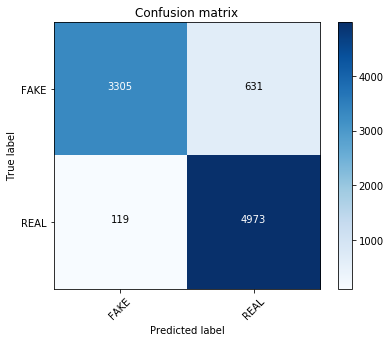

In [89]:
# naive bayes model
nb_classifier = MultinomialNB(alpha=0.1)
nb_classifier.fit(X_train, y_train)
pred = nb_classifier.predict(X_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy with Multinomial Naive Bayes:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy:  0.876


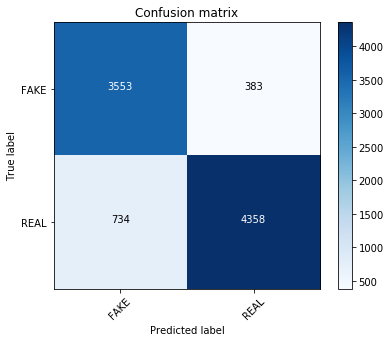

In [90]:
# random forest model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
pred = rf_classifier.predict(X_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy:  %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

      Iter       Train Loss   Remaining Time 
         1           1.2703            5.58m
         2           1.1854            5.31m
         3           1.1151            5.19m
         4           1.0557            5.09m
         5           1.0043            5.03m
         6           0.9600            4.97m
         7           0.9213            4.91m
         8           0.8872            4.86m
         9           0.8574            4.80m
        10           0.8309            4.74m
        20           0.6558            4.20m
        30           0.5606            3.65m
        40           0.4981            3.14m
        50           0.4552            2.60m
        60           0.4176            2.07m
        70           0.3894            1.55m
        80           0.3663            1.03m
        90           0.3456           31.07s
       100           0.3284            0.00s
Accuracy:   0.941


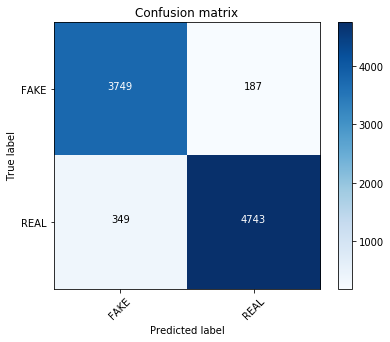

In [91]:
# gradient boost model
gb_classifier = GradientBoostingClassifier(verbose=True)
gb_classifier.fit(X_train, y_train)
pred = gb_classifier.predict(X_test)

# accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy:   %0.3f" % score)

# confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

<h2>Predicting for new data...</h2>

In [114]:
# Take input from user for new data point prediction
new_data = pd.DataFrame()

headline = input("Enter the headline of article: \n")
body = input("Enter the body of article: \n")

# headline = "Obama Signs Executive Order Declaring Investigation Into Election Results; Revote Planned For Dec. 19th - ABC News"
# body = """64 SHARE President Obama has signed an Executive Order declaring an investigation into the election results and plans for a revote on December 19th. (AP Photo / Dennis System) 
# WASHINGTON, D.C. (AP) — Following the results of Tuesday night’s election, President Obama has signed Executive Order 13805 , which orders a full recount of all votes cast in the election and calls for a special election to be held on December 19 th . Obama signed the order in response to the concerns of thousands of voters across the country who said that they were prevented from casting a ballot on election day , too many absentee ballots have not been found or counted , equipment failures, as well as concerns that some members of the electoral college may have acted unethically. 
# “People all over the country have been flooding my office with calls, telling my staff of horror stories about being harassed and intimidated by poll workers,” Obama told reporters. “Many have even said that they were flat out denied entry into the voting booths to cast their ballots if they were wearing a Hillary Clinton shirt or other signs showing support for her as President. This was especially bad in areas of Florida and North Carolina where there are high numbers of Latino and African American voters. We must investigate these claims. The margin of victory is too close to call, and the outcome of this election is too important. There is just too many legal challenges in too many states to just call this a victory for Trump.” 
# Under the President’s order, the votes cast in all precincts nationwide will be recounted, and all poll workers who took part in Tuesday’s election will be subjected to strict background checks. This process is expected to take 30 days. In precincts where the Department of Justice has cause to believe that voter suppression has occurred, new elections will be held on Dec. 19 th, with those results being used to help determine who will represent the individual states in the electoral college. 
# Not surprisingly, Donald Trump is not happy with the president’s decision. 
# “Crooked Hillary lost this election fair and square. They tried to rig this election against me, but the American people didn’t allow that to happen. President Obama doesn’t care about what the American people want. I said the system was rigged all along, and this proves I was right.” 
# The president also said that the DOJ will be taking a close look at the members of the electoral college. 
# “We have received information from a very reliable source that suggests there may have been some collusion between the members of the electoral college and poll workers in certain swing states. We still need to investigate these claims, but if they are true, we will take all the appropriate actions necessary.” 
# Paul Horner, a professor of political science at UCLA, believes that the issues with the electoral college run much deeper that this election. 
# “Most people feel that it is their right as citizens to pick the president of the United States, but there is nothing in the constitution that says that. Hillary Clinton won the popular vote by more than 200,000 votes , but because of the electoral college, she still lost. That decision is reserved solely for the 538 electors who meet in their respective states on December 19 th . What the people are actually voting for are their states’ electors, not for the President. Though the system is odd and unfair, it has persisted because many insist that it works just fine as it is, with the winner of the popular and electoral vote usually matching. That does not mean, however, that it will continue to work just fine in the future. The way the system is set up could cause it to malfunction in some potentially terrifying ways, this recent election being one of them.” 
# Political Analyst Matt Daemon told ABC News that he agrees with the President’s Executive Order and said that he would like to see the electoral college done away with altogether. 
# “[The electoral college] is a f—king joke; we should be using the popular vote instead. It may have made sense in 1788, but so did the three fifths compromise . Everyone should have an equal vote, and that’s just not the case with the electoral college. You know what the electoral college gave us? It gave us George W. Bush. It gave us a war in Iraq, and the worst recession since the great depression. It’s time to bring our system into the 21 st century. I hope Obama fixes this, because president Trump is going to be a nightmare.” 
# Obama finished up the press conference explaining his plans for moving forward. 
# “We’re going to investigate the FBI into their role in all of this,” Obama said. “Why did FBI director James Comey on Sunday say that the agency is not recommending charges against Clinton after reviewing all of her emails; declaring Hillary Clinton a free women conveniently just one day before the election? Why wasn’t this news released earlier? How many votes were lost because of this?” Obama said. “If all of these questions cannot be answered by our deadline set in December, a recount will be ordered.” 
# If you have any questions about the recount or the special December 19 th election , you can call the Obama administration’s special election hotline at (785) 273-0325. TAGS"""

new_data['Headline'] = [headline]
new_data['Body'] = [body]

# combine headline and body into text
new_data['Text'] = new_data['Headline'] + new_data['Body']

# apply clean_text on new data point
new_data['Clean_Text'] = new_data['Text'].apply(lambda x: clean_text(x))
new_data.head()


Enter the headline of article: 
 Brexit Encourages UK to Trade With Non-EU States, Including Russia
Enter the body of article: 
 Britain and EU After Brexit ( 31 ) 0 13 0 0 Brexit prompts the Unietd Kingdom to facilitate trade relations with non-EU states including Russia, the Russo-British Chamber of Commerce (RBCC) chairman told Sputnik.  MOSCOW (Sputnik) — Leaving the European Union and losing access to the single market encourages Britain to develop trade with Russia and other non-EU states, Roger Munnings, the Russo-British Chamber of Commerce (RBCC) chairman, told Sputnik on Wednesday. "There are at least two years to go before we leave the European Union, but I think the way Britain is looking at it is that it gives us a chance to be completely open to all countries in the world, including Russia. We’ll need to look for other trading partners rather than being confined to the European Union by virtue of the free trade arrangement, so we will be very keen to do trade with Russia,

,Headline,Body,Text,Clean_Text
0,Brexit Encourages UK to Trade With Non-EU Stat...,Britain and EU After Brexit ( 31 ) 0 13 0 0 Br...,Brexit Encourages UK to Trade With Non-EU Stat...,brexit encourages uk trade noneu state includi...


In [115]:
# transform using TFIDF vectorizier
tfidf = tfidf_vectorizer.transform(new_data['Clean_Text'])

In [116]:
# generate POS tags for new data point
pos_tags_column = []
pos_tags = []
doc = nlp(new_data['Text'][0])
for token in doc:
    pos_tags.append(token.pos_)
all_pos_tags = ' '.join(pos_tags)
pos_tags_column.append(all_pos_tags)

new_data['Text_POS'] = pos_tags_column
new_data.head()


,Headline,Body,Text,Clean_Text,Text_POS
0,Brexit Encourages UK to Trade With Non-EU Stat...,Britain and EU After Brexit ( 31 ) 0 13 0 0 Br...,Brexit Encourages UK to Trade With Non-EU Stat...,brexit encourages uk trade noneu state includi...,PROPN VERB PROPN ADP PROPN ADP PROPN PUNCT PRO...


In [117]:
# transform using TFIDF POS vectorizer
pos_tfidf = pos_tfidf_vectorizer.transform(new_data['Text_POS'])


In [118]:
# generate semantic scores for new data point
semantic = []


d = lexicon.analyze(new_data['Text'][0], normalize=False)
x = []
for key, value in d.items():
    x.append(value)
    
x = np.asarray(x)
semantic.append(x)

new_data['Semantic'] = semantic
new_data['Semantic'].head()


0    [0.0, 1.0, 0.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Semantic, dtype: object

In [119]:
categories = []
a = lexicon.analyze("")
for key, value in a.items():
    categories.append(key)
categories

['help',
 'office',
 'dance',
 'money',
 'wedding',
 'domestic_work',
 'sleep',
 'medical_emergency',
 'cold',
 'hate',
 'cheerfulness',
 'aggression',
 'occupation',
 'envy',
 'anticipation',
 'family',
 'vacation',
 'crime',
 'attractive',
 'masculine',
 'prison',
 'health',
 'pride',
 'dispute',
 'nervousness',
 'government',
 'weakness',
 'horror',
 'swearing_terms',
 'leisure',
 'suffering',
 'royalty',
 'wealthy',
 'tourism',
 'furniture',
 'school',
 'magic',
 'beach',
 'journalism',
 'morning',
 'banking',
 'social_media',
 'exercise',
 'night',
 'kill',
 'blue_collar_job',
 'art',
 'ridicule',
 'play',
 'computer',
 'college',
 'optimism',
 'stealing',
 'real_estate',
 'home',
 'divine',
 'sexual',
 'fear',
 'irritability',
 'superhero',
 'business',
 'driving',
 'pet',
 'childish',
 'cooking',
 'exasperation',
 'religion',
 'hipster',
 'internet',
 'surprise',
 'reading',
 'worship',
 'leader',
 'independence',
 'movement',
 'body',
 'noise',
 'eating',
 'medieval',
 'zest',


In [120]:
# generate semantic categories for new data point
sem = []
for i in range(new_data.shape[0]):
    a = []
    for j in range(len(semantic[0])):
        for k in range(int(semantic[i][j])):
            a.append(categories[j])
    b = ' '.join(a)
    sem.append(b)
new_data['Semantics'] = sem

print(new_data['Semantics'].head())

0    office money money money money money wedding w...
Name: Semantics, dtype: object


In [121]:
new_data.head()

,Headline,Body,Text,Clean_Text,Text_POS,Semantic,Semantics
0,Brexit Encourages UK to Trade With Non-EU Stat...,Britain and EU After Brexit ( 31 ) 0 13 0 0 Br...,Brexit Encourages UK to Trade With Non-EU Stat...,brexit encourages uk trade noneu state includi...,PROPN VERB PROPN ADP PROPN ADP PROPN PUNCT PRO...,"[0.0, 1.0, 0.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...",office money money money money money wedding w...


In [122]:
# transform using TFIDF semantic vectorizer
sem_tfidf = sem_tfidf_vectorizer.transform(new_data['Semantics'].astype('str'))

In [123]:
# Combine all 3 sparse matrices to form test data point
diff_n_rows = pos_tfidf.shape[0] - tfidf.shape[0]
b = sp.vstack((tfidf, sp.csr_matrix((diff_n_rows, tfidf.shape[1]))))
c = sp.hstack((pos_tfidf, b))

diff_n_rows = c.shape[0] - sem_tfidf.shape[0]
b = sp.vstack((sem_tfidf, sp.csr_matrix((diff_n_rows, sem_tfidf.shape[1]))))
X = sp.hstack((c, b))

<h3>Result</h3>

In [124]:
# prediction
pred = gb_classifier.predict(X)
print(pred)

# probalitistic prediction 
print(gb_classifier.predict_proba(X))

['FAKE']
[[0.87747567 0.12252433]]
